# Subhalo parameters
This uses the output of the `parameterize-all.py` script, which itself analyzes the particle distribution in the selected halos' HDF5 files.

In [1]:
%matplotlib inline

In [2]:
from pylab import *
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120
import os, scipy.interpolate
from IPython.core.display import display, HTML

In [3]:
data_path = './results'
defualt_file_name = 'subhalo_411321_parameters.dat'
if 'COSMORELAY_HALO_NUM' in os.environ:
    file_name = 'subhalo_%s_parameters.dat' % os.environ['COSMORELAY_HALO_NUM']
else:
    display(HTML('<span style="color: red; font-weight: bold;">NOTE:</span> using the default file name. Custom halo number could be set through the <span style="font-family: mono;">COSMORELAY_HALO_NUM</span> environment variable.'))
    file_name = defualt_file_name
file_name = os.path.join(data_path, file_name)

In [4]:
data = loadtxt(file_name)
snapshot       = data[:,0]
t              = data[:,1]
X_center_stars = data[:,2:5]
phi_inertia    = data[:,5]
theta_inertia  = data[:,6]
phi_L          = data[:,7]
theta_L        = data[:,8]
M_disk         = data[:,9]
a_mn           = data[:,10]
b_mn           = data[:,11]
X_center_halo  = data[:,12:15]
M_halo_plummer = data[:,15]
b_halo_plummer = data[:,16]
rho_0_nfw      = data[:,17]
b_nfw          = data[:,18]
lsq_nfw        = data[:,19]

## Halo and disk comparison
This compares the mass of the halo (i.e. total mass of dark matter and gas particles) with the mass of the disk (i.e. total mass of star particles).

Halo is on average x52 more massive than the disk


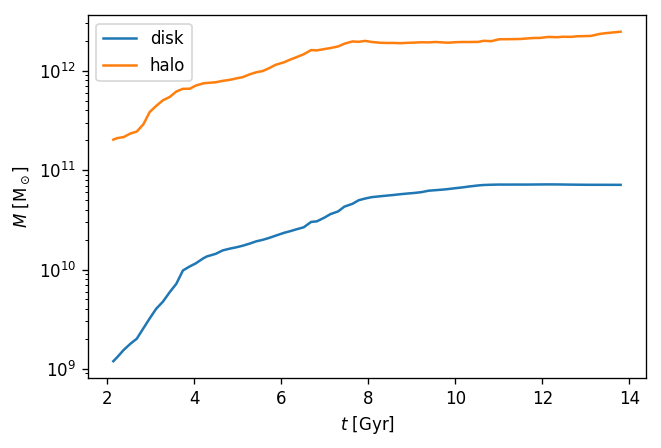

In [5]:
semilogy(t, M_disk)
semilogy(t, M_halo_plummer)
xlabel('$t$ [Gyr]')
ylabel('$M\ [\mathrm{M}_\odot]$')
legend(('disk', 'halo'))
print(f'Halo is on average x{mean(M_halo_plummer/M_disk):.0f} more massive than the disk')

## Shift between the halo and disk density centres

Maximum distance between stellar and halo centres is 0.76 kpc


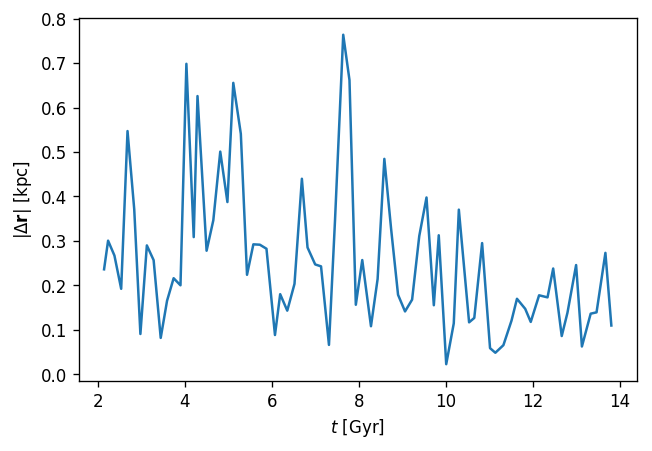

In [6]:
distance = linalg.norm(X_center_stars - X_center_halo, axis=1)
plot(t, distance)
xlabel('$t$ [Gyr]')
ylabel(r'$|\Delta \mathbf{r}|$ [kpc]')
print(f'Maximum distance between stellar and halo centres is {distance.max():.2f} kpc')

## Disk length scales

Text(0, 0.5, '$b/a$')

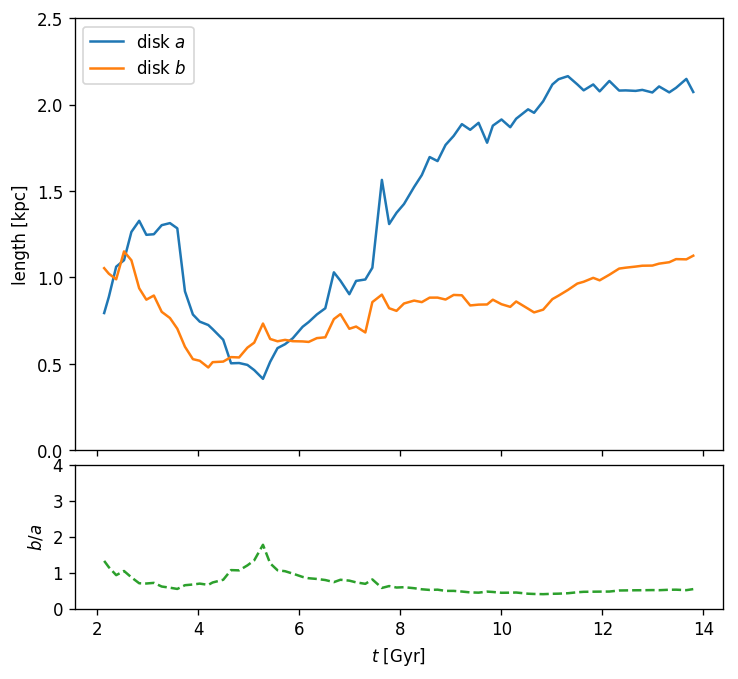

In [7]:
axes([0.05,0.33,0.9,0.9])
plot(t, a_mn)
plot(t, b_mn)
legend(('disk $a$', 'disk $b$'))
ylabel('length [kpc]')
ylim(0, 2.5)
gca().set_xticklabels([])
axes([0.05,0.0,0.9,0.3])
plot(t, b_mn/a_mn, '--', c='C2')
ylim(0,4)
xlabel('$t$ [Gyr]')
ylabel('$b/a$')

## Orientation of the disk
This plots the disk's orientation (direction of its minor axis) according to quadrupole tensor and angular momentum analyses.

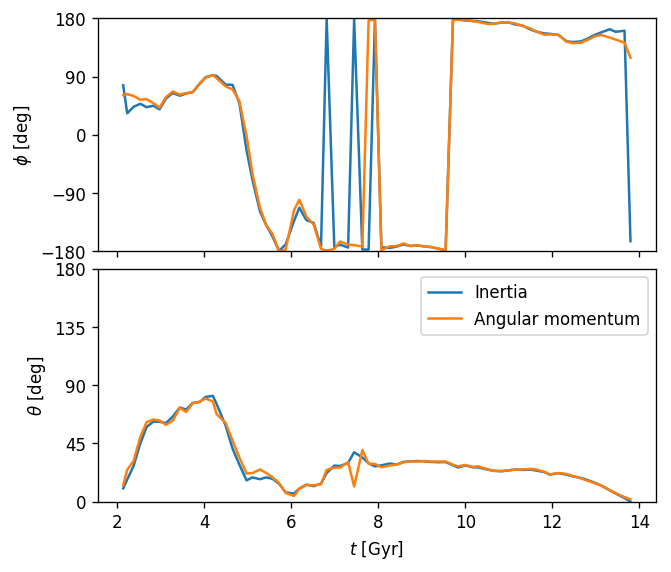

In [8]:
figsize = rcParams['figure.figsize']
figure(figsize=[figsize[0], figsize[1]*4/3])
subplot(211)
plot(t, rad2deg(phi_inertia))
plot(t, rad2deg(phi_L))
ylabel(r'$\phi$ [deg]')
ylim(-180,180)
gca().set_xticklabels([])
gca().yaxis.set_ticks([-180,-90,0,90,180])
subplot(212)
plot(t, rad2deg(theta_inertia))
plot(t, rad2deg(theta_L))
xlabel(r'$t$ [Gyr]')
ylabel(r'$\theta$ [deg]')
gca().yaxis.set_ticks([0,45,90,135,180])
ylim(0,180)
legend(('Inertia', 'Angular momentum'))
subplots_adjust(hspace=0.075)

## Avoiding discontinuity in $\phi$
Since $\phi$ has a range of between –180° to +180°, it could have unphysical jumps in the time curve when rolling over. Here we attempt to fix it.

Text(0, 0.5, '$\\phi$ [deg]')

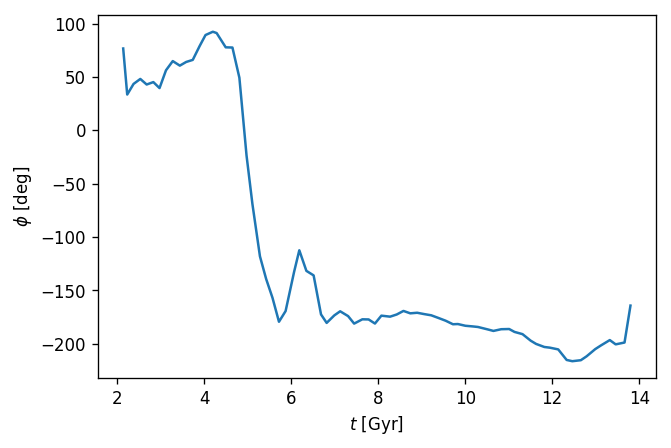

In [9]:
def fix_continuity(input_array, threshold_factor=0.8):
    arr = input_array.copy()
    threshold = threshold_factor*2*pi
    for i in range(1, len(arr)):
        if arr[i] - arr[i-1] >  threshold: arr[i] -= 2*pi
        if arr[i] - arr[i-1] < -threshold: arr[i] += 2*pi
    return arr
phi_inertia_fixed = fix_continuity(phi_inertia)
plot(t, rad2deg(phi_inertia_fixed))
xlabel(r'$t$ [Gyr]')
ylabel(r'$\phi$ [deg]')

## NFW parameter
Plotting the two NFW parameters $\rho_0$ and $b$. The bottom graph is the sum of squares divided by number of data points (indicates goodness of fit).

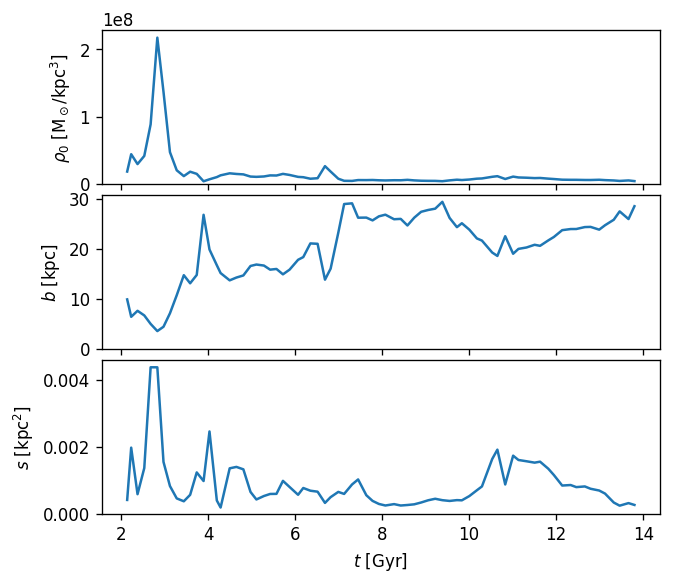

In [10]:
figsize = rcParams['figure.figsize']
figure(figsize=[figsize[0], figsize[1]*4/3])
subplot(311)
plot(t, rho_0_nfw)
ylim(bottom=0)
ylabel(r'$\rho_0$ [$\mathrm{M}_\odot/\mathrm{kpc}^3$]')
gca().set_xticklabels([])
subplot(312)
plot(t, b_nfw)
ylim(bottom=0)
ylabel(r'$b$ [kpc]')
gca().set_xticklabels([])
subplot(313)
plot(t, lsq_nfw)
ylabel(r'$s$ [$\mathrm{kpc}^2$]')
ylim(bottom=0)
xlabel(r'$t$ [Gyr]')
subplots_adjust(hspace=0.075)

In [11]:
output_file_name = file_name[:-4] + '_processed.dat'
with open(output_file_name, 'w') as f:
    for i in range(len(snapshot)):
        output_string = '%d %.8E   %15.8E %15.8E   %.8E %.8E %.8E   %.8E %.8E\n' % (
            snapshot[i],
            t[i],
            phi_inertia_fixed[i], theta_inertia[i],
            M_disk[i], a_mn[i], b_mn[i],
            rho_0_nfw[i], b_nfw[i],
        )
        f.write(output_string)